In [1]:
import json
import matplotlib.pyplot as plt
from scipy.stats import binomtest

In [2]:
with open('gpt3.5-turbo-instruct big n.json') as f:
    data = json.load(f)

def count_results(data):
    counted = {}
    for d in data:
        question_def = d['question_def']

        depth = question_def['depth']
        num_values = question_def['num_values']
        on_right = question_def['question_on_right']

        was_correct = d['value'] == d['gt_answer']

        key = (depth, num_values, on_right)
        if key not in counted:
            counted[key] = {
                "correct": 0,
                "is_null": 0,
                "total": 0,
            }
        counted[key]["correct"] += was_correct
        counted[key]["is_null"] += d['value'] is None
        counted[key]["total"] += 1
    return counted

counted = count_results(data)

In [3]:
def results_at_depth(counted_results, depth_slice: int, key = 'correct'):
    left_results = []
    right_results = []
    for k, r in counted_results.items():
        depth, num_values, on_right = k
        if depth == depth_slice:
            if on_right:
                right_results.append((num_values, r[key], r['total']))
            else:
                left_results.append((num_values, r[key], r['total']))
    left_results.sort()
    right_results.sort()
    return left_results, right_results

def CIs(points) -> list[list[tuple[float, float]]]:
    lines = [[], [], []]
    for x, k, n in points:
        p = k / n
        ci = binomtest(k, n).proportion_ci()
        lines[0].append((x, p))
        lines[1].append((x, ci[0]))
        lines[2].append((x, ci[1]))
    return lines

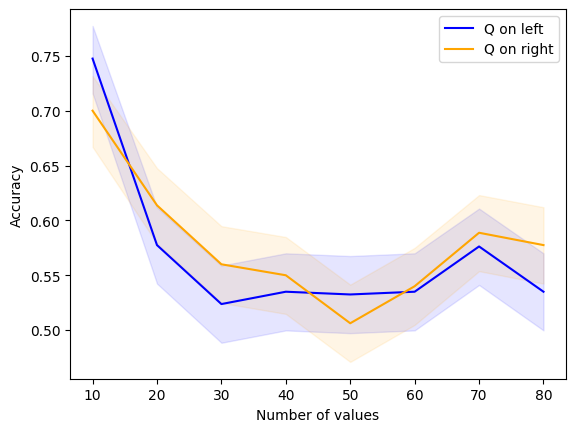

In [4]:
# On Left vs On Right at Depth 1 across dataset
left_q, right_q = results_at_depth(counted, 1)
lp, ll, lh = CIs(left_q)
rp, rl, rh = CIs(right_q)

def plot_ci(lines, color, label):
    x = [x for x, _ in lines[0]]
    y = [y for _, y in lines[0]]
    yl = [y for _, y in lines[1]]
    yh = [y for _, y in lines[2]]
    # plt.plot(x, yl, color=color)
    plt.plot(x, y, color=color, label=label)
    # plt.plot(x, yh, color=color)
    plt.fill_between(x, yl, yh, color=color, alpha=0.1)

plot_ci([lp, ll, lh], 'blue', 'Q on left')
plot_ci([rp, rl, rh], 'orange', 'Q on right')
plt.ylabel('Accuracy')
plt.xlabel('Number of values')
plt.legend()
plt.show()
